# Importations 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import gc ,random 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn import model_selection

import cv2
import SimpleITK as sitk
from ipywidgets import interact, fixed
from tqdm import tqdm 
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup
import albumentations as A 

from collections import OrderedDict
from sklearn.model_selection import train_test_split

from loss.dice import * 
from loss.ssim import * 
from models.UNet import *
from datasets.merging_dataset import * 

In [3]:
# SEED Everything 
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Utils 

In [4]:
def display(image_z, fixed):
    fig, axs = plt.subplots(figsize=(10,8))
    axs.imshow(sitk.GetArrayViewFromImage(fixed[:,:,image_z]), cmap='hot', interpolation='nearest');
    plt.show()

In [5]:
def display_images_with_Label(image_z , alpha , im_orginal , Label  ):
    fig, axs = plt.subplots(1,2,figsize=(20,8))
    im = (1-alpha) * im_orginal + alpha * (sitk.Cast(Label, sitk.sitkFloat32) )
    axs[0].imshow(sitk.GetArrayFromImage(im[:,:,image_z]),cmap=plt.cm.Greys_r);
    axs[1].imshow(sitk.GetArrayFromImage(sitk.LabelToRGB(Label)[:,:,image_z]));

In [6]:
def visualize_results(image_z   , label , label_hat): 
    fig, axs = plt.subplots(1,2,figsize=(20,8))

    axs[0].imshow(sitk.GetArrayFromImage(sitk.LabelToRGB(label)[:,:,image_z]));
    axs[0].set_title('Real mask')
  
    axs[1].imshow(sitk.GetArrayFromImage(sitk.LabelToRGB(label_hat)[:,:,image_z]));
    axs[1].set_title('predicted mask')

In [7]:
def soft_max_2d(pred) : 
    s = pred.shape 
    y_final = torch.randn((s[0],s[2],s[3]))
    for i in range(s[2]) : 
        for j in range(s[3]) : 
            y_final[:,i,j] = F.softmax(pred[:,:,i,j],dim = 1 ).argmax(dim=1)
    
    return y_final 

In [8]:
def dice(pred, target, smooth = 0.00001):
    
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    loss_label_1 = 1-loss[:,1].mean()
    loss_label_2 = 1-loss[:,2].mean()
    loss_label_3 = 1-loss[:,3].mean()
    loss_over_all = 1 - loss.mean().mean()
    
    return  loss_label_1 , loss_label_2 ,loss_label_3 , loss_over_all 

In [9]:
def loss_eval  (data_set, model , device , merging = False):
   
    data_loader = torch.utils.data.DataLoader(
        data_set,
        batch_size=128,
        num_workers=8
    )

    model.eval()
    tr_loss = 0
    counter = 0
    
    label1_loss  = 0
    label2_loss  = 0 
    label3_loss  = 0 
   

    with torch.no_grad():
        
        for bi, d in enumerate(data_loader):
            
            y = d["label"].to(device, dtype=torch.float)
            x = d["LR"].to(device, dtype=torch.float) 
            y_hat   = model(x.unsqueeze(1)) #forward prop 
            
            if merging : 
                y_hat = y_hat[:,1:,:,:]

                
            if bi == 0 :
                full_x = x
                full_y = y
                y_final = y_hat 
            else :
                full_x = torch.cat([full_x , x] , dim = 0 ) 
                full_y = torch.cat([full_y , y] , dim = 0 )  
                y_final= torch.cat([y_final , y_hat] , dim = 0 )  
                
            
        y_final = soft_max_2d(y_final)
        y_final = torch.cat([ (y_final==0).type(torch.long).unsqueeze(1) ,(y_final==1).type(torch.long).unsqueeze(1),(y_final==2).type(torch.long).unsqueeze(1),(y_final==3).type(torch.long).unsqueeze(1) ],dim = 1)
        y_final = y_final.to(device)

        labels = dice(y_final, full_y) # Loss calaculation of batch i 
    return labels[0].item() ,  labels[1].item() , labels[2].item() , labels[3].item() 

In [10]:
def bar_plot_validation(df,Left = True ) : 
    
    results = np.zeros((6,5,4))
    
    if Left : 
        a = 'Left' 
    else :
        a = 'Right'
    for f in tqdm(range(5)) : 
        
        PATH_UNet = f'trained_model/UNet_segmentation/Unet Left fold {f}.pt'
        PATH_GAN = f'trained_model/GAN_segmentation/GAN Left fold {f}.pt'
        PATH_CUNet = f'trained_model/Casceded UNet/Seg Cascaded Unet V2 Left fold {f}.pt'
        PATH_PCUNet = f'trained_model/PCasceded UNet/Seg PCascaded Unet V2 Left fold {f}.pt'
        PATH_GANCUNet = f'trained_model/Casceded UNet/GAN Seg Cascaded Unet V2 Left fold {f}.pt'
        PATH_GANPCUNet = f'trained_model/PCasceded UNet/GAN Seg PCascaded Unet V2 Left fold {f}.pt'
        
        subject_df = df[df['kfold']==f]
        subject_df_dataset =  Merging_data_set(subject_df ,  subjects  , Left = True , is_train = False)
        
        model = UNet(1,4,segmentation = False )
        model = model.to(device) 
        model.load_state_dict(torch.load(PATH_UNet))
        score = loss_eval(subject_df_dataset,model,device) 
        
        results[0,f,0] = score[0]
        results[0,f,1] = score[1]
        results[0,f,2] = score[2]
        results[0,f,3] = score[3]
        
        model = UNet(1,4,segmentation = False )
        model = model.to(device)
        model.load_state_dict(torch.load(PATH_GAN))
        score = loss_eval(subject_df_dataset,model,device) 
        
        results[1,f,0] = score[0]
        results[1,f,1] = score[1]
        results[1,f,2] = score[2]
        results[1,f,3] = score[3]
        
       
        
        model = CascadedUNet( )
        model = model.to(device)
        model.load_state_dict(torch.load(PATH_CUNet))
        score = loss_eval(subject_df_dataset,model,device) 
        
        results[2,f,0] = score[0]
        results[2,f,1] = score[1]
        results[2,f,2] = score[2]
        results[2,f,3] = score[3]
        
        model = ParallelCascadedUNet()
        model = model.to(device)
        model.load_state_dict(torch.load(PATH_PCUNet))
        score = loss_eval(subject_df_dataset,model,device) 
        
        results[3,f,0] = score[0]
        results[3,f,1] = score[1]
        results[3,f,2] = score[2]
        results[3,f,3] = score[3]
        
        model = GANCascadedUNet()
        model = model.to(device)
        model.load_state_dict(torch.load(PATH_GANCUNet))
        score = loss_eval(subject_df_dataset,model,device) 
        
        results[4,f,0] = score[0]
        results[4,f,1] = score[1]
        results[4,f,2] = score[2]
        results[4,f,3] = score[3]
        
        model = GANParallelCascadedUNet()
        model = model.to(device)
        model.load_state_dict(torch.load(PATH_GANPCUNet))
        score = loss_eval(subject_df_dataset,model,device) 
        
        results[5,f,0] = score[0]
        results[5,f,1] = score[1]
        results[5,f,2] = score[2]
        results[5,f,3] = score[3]
    
    models = ['UNet','GAN','CUNet','PCUNet', 'GANCUnet' ,'GANPCUnet' ]
    labels = ['Subiculum', 'CA1-3' , 'CA4-DG' , 'Overall']
    data_results = None
    for num , m in enumerate(models) : 
        temp= pd.DataFrame()
        temp['model'] = [m] * 20 
        temp['label'] = [labels[0]] * 5 + [labels[1]] * 5 + [labels[2]] * 5 + [labels[3]] * 5
        temp['dice_score'] = np.concatenate([results[num,:,0],results[num,:,1],results[num,:,2],results[num,:,3]] , axis = 0)
        data_results = pd.concat([data_results,temp], axis = 0)
    return data_results 

# Introduction 

In [11]:
data = pd.read_csv('data_5fold.csv')
subjects = data[data['slice']==0]

# Model 1 : UNet 

## Model Description 

Original paper by Olaf Ronneberger, Philipp Fischer, Thomas Brox: https://arxiv.org/abs/1505.04597

![](https://miro.medium.com/max/963/1*lvXoKMHoPJMKpKK7keZMEA.png)


UNet was first model designed especially for medical image segmentation. It showed such good results that it used in many other fields after.

The main idea behind CNN is to learn the feature mapping of an image and exploit it to make more nuanced feature mapping. This works well in classification problems as the image is converted into a vector which used further for classification. But in image segmentation, we not only need to convert feature map into a vector but also reconstruct an image from this vector. This is a mammoth task because it’s a lot tougher to convert a vector into an image than vice versa. The whole idea of UNet is revolved around this problem.

While converting an image into a vector, we already learned the feature mapping of the image so why not use the same mapping to convert it again to image. This is the recipe behind UNet. Use the same feature maps that are used for contraction to expand a vector to a segmented image. This would preserve the structural integrity of the image which would reduce distortion enormously. 


## Loss Function 

The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:

![](https://miro.medium.com/max/321/1*EF3VCtk-VbTIKhriaQF0YQ.png)


where pi and gi represent pairs of corresponding pixel values of prediction and ground truth, respectively.

# Model 2: GAN Generative model based on UNet

## Model Description 

### Generative adversarial network 

Te generative adversarial network, which consists of two components: a generator G
and a discriminator D, is a deep learning framework that trains the generative model and
the discriminative model alternately. The general idea of the generative adversarial network is an adversarial process amongst the models pitting against each other to improve the performance of the networks, where the generator counterfeits the sample images to
deceive the discriminator and the discriminative model determines whether the images are
fake or not. 

![](https://nhoues.github.io/Segmentation-of-hippocampal/Images/GAN.PNG)

In our case, we will use the generative model to generate the segmentation of the hippocampus in the brain. and then the adversarial model try to discriminate the generative segmentations from the expert manual segmentations.

### Generative network

we have used the **UNet** architecture as an Generative network in our Model.

## Adversarial network 

![](https://nhoues.github.io/Segmentation-of-hippocampal/Images/Adversial.PNG)

The adversarial model takes the hipocampal image and the corresponding label map as input. The label map is either the
expert segmentations or produced by the generative model. then  a binary class probability
is produced to determine whether the label map is the expert segmentation or not.

## Loss Function 

The Loss function formula of the generative adversarial network is as follows:


$$ l(\:\theta_g ,\:\theta_a\:) = \sum_{n=1}^{N} \: \:\:l_{mce}(g(x_n),y_n) - [ \: l_{bce}(\:a(x_n,y_n),1\:) + l_{bce}(\:a(x_n,g(x_n)),0\:)\:]$$

Where :
* $x_n$ denotes input image  with the size of H×W
* $y_n$ corresponding label maps of $x_n$  
* $g(x) $  denotes the class probability map over M classes
* a(x, y)∈[0,1]  denotes the probability predicted by the adversarial model
*  $\theta_g$, $\theta_a$ are the parameters of the generative model and of the adversarial model respectively.
* $ l_{mce}( \hat{y} , y ) = - \sum_{i=1}^{H \times W }\: \sum_{m=1}^{M} \: y_{im} ln (\hat{y_{im}}) $ : denotes the multiclass cross-entropy loss 

* $ l_{bce}(\hat{a} ,a ) = = − a \: ln (\hat{a}) + (1 − a) \:ln( 
1 − \hat{a}) $ : denotes the binary cross entropy loss . 

When training the generative model, we minimize the loss with respect to θg, while maximizing it with respect to θa when training the
adversarial model.

### Implementation 

In [12]:
class Adeversarial(nn.Module) : 
    def __init__(self,in_channels = 5 ) : 
        super(Adeversarial,self).__init__( ) 
        
        self.full_model = nn.Sequential(
                                            nn.Conv2d(in_channels , 64 , kernel_size = 5 ) , 
                                            nn.ReLU(inplace=True) , 
                                            nn.MaxPool2d(kernel_size = 2 , stride=2),

                                            nn.Conv2d(64, 128 , kernel_size = 5 ) , 
                                            nn.ReLU(inplace=True) , 
                                            nn.MaxPool2d(kernel_size = 2 , stride=2),

                                            nn.Conv2d(128, 128 , kernel_size = 3 ) , 
                                            nn.ReLU(inplace=True) , 
                                            nn.MaxPool2d(kernel_size = 2 , stride=2),

                                            nn.Conv2d(128, 256 , kernel_size = 3 ) , 
                                            nn.ReLU(inplace=True) , 
                                            nn.MaxPool2d(kernel_size = 2 , stride=2),

                                            nn.Conv2d(256, 512 , kernel_size = 3 ) , 
                                            nn.ReLU(inplace=True) ,

                                            nn.Conv2d(512, 2 , kernel_size = 3 ) ,
                                            nn.Sigmoid() , 
                                        )
    def forward(self,image ) : 
        
        x_hat = self.full_model(image)
        return(x_hat[:,:,0,0])

# Model 3: Merging UNet 

## Model description 

![](https://nhoues.github.io/Segmentation-of-hippocampal/Images/MergeUnet.PNG)

## Loss function 

$$ Loss( y_{seg-hat} , y_{seg} , y_{rec-hat} ,y_{rec}) = (diceloss(y_{seg-hat} , y_{seg} ) + ssimloss(y_{rec-hat} , y_{rec}) ) /2$$

# Model 4 : Cascaded UNet 

![](https://nhoues.github.io/Segmentation-of-hippocampal/Images/cascaded_unet.PNG)

## Implementation

In [13]:
class ParallelCascadedUNet(nn.Module) : 
    def __init__(self) :
        super(ParallelCascadedUNet,self).__init__()
        
        self.segmentation_1  = UNet(1,4, segmentation = False) 
        self.segmentation_2  = UNet(2,4, segmentation = False)
        self.segmentation_3  = UNet(2,4, segmentation = False)
        
        self.reconstruction_1 = UNet(1,1, segmentation = False)
        self.reconstruction_2 = UNet(5,1, segmentation = False)
        self.reconstruction_3 = UNet(5,1, segmentation = False)
    
    def forward(self,image) :
        seg_1 = self.segmentation_1(image) 
        rec_1 = self.reconstruction_1(image)
        
        x_hr_lr = torch.cat([rec_1,image] , dim =1)
        seg_2  = self.segmentation_2(x_hr_lr) 
        
        c_seg = self.construct_seg(seg_1)
        x_merge = torch.cat([image,c_seg] , dim = 1 )
        rec_2 = self.reconstruction_2(x_merge)
        
        x_hr_lr = torch.cat([rec_2,image] , dim =1)
        seg_3  = self.segmentation_3(x_hr_lr) 
        
        c_seg = self.construct_seg(seg_2)
        x_merge = torch.cat([image,c_seg] , dim = 1 )
        rec_3 = self.reconstruction_3(x_merge)
        
        return seg_3
    def construct_seg(self,x) : 
        y_1 = torch.argmax(nn.Softmax2d()(x) , dim=1)
        x_label_0 = (y_1==0).type(torch.long).unsqueeze(1)
        x_label_1 = (y_1==1).type(torch.long).unsqueeze(1)
        x_label_2 = (y_1==2).type(torch.long).unsqueeze(1)
        x_label_3 = (y_1==3).type(torch.long).unsqueeze(1)
        generated_segmenation = torch.cat([x_label_0,x_label_1,x_label_2,x_label_3] , dim = 1)
        generated_segmenation = generated_segmenation.type(torch.float)
        return generated_segmenation 

# Model 5: parallel Cascaded UNet 

## Model description 

![](https://nhoues.github.io/Segmentation-of-hippocampal/Images/pc_unet.PNG)

## Implementation

In [14]:
class CascadedUNet(nn.Module) : 
    def __init__(self) :
        super(CascadedUNet,self).__init__()
        self.layer_1  = UNet(1,1, segmentation = False) 
        self.layer_2  = UNet(2,4, segmentation = False)
        self.layer_3  = UNet(6,1, segmentation = False)
        self.layer_4  = UNet(2,4, segmentation = False)
        self.layer_5  = UNet(6,1, segmentation = False)
    def forward(self,image) :
        
        hr_1 = self.layer_1(image)
        im = torch.cat([hr_1,image],dim=1)
        
        seg_1 = self.layer_2(im)
        
        seg_t = self.segmentation_gen(seg_1)
        im = torch.cat([hr_1,image,seg_t*image],dim=1)
        
        hr_2 = self.layer_3(im) 
        
        im = torch.cat([hr_2,image],dim=1)
        seg_2 = self.layer_4(im)
        
        seg_t = self.segmentation_gen(seg_2) 
        
        im = torch.cat([hr_2,image,seg_t*image],dim=1)
        hr_3 = self.layer_5(im)
        
        return seg_2
    def segmentation_gen(self,x) : 
        
        y_1 = torch.argmax(nn.Softmax2d()(x) , dim=1)
        x_label_0 = (y_1==0).type(torch.long).unsqueeze(1)
        x_label_1 = (y_1==1).type(torch.long).unsqueeze(1)
        x_label_2 = (y_1==2).type(torch.long).unsqueeze(1)
        x_label_3 = (y_1==3).type(torch.long).unsqueeze(1)
        y_1 = torch.cat([x_label_0,x_label_1,x_label_2,x_label_3] , dim = 1)
        y_1 = y_1.type(torch.float)
        
        return y_1 
        
        
        

In [15]:
class GANCascadedUNet(nn.Module) : 
    def __init__(self) :
        super(GANCascadedUNet,self).__init__()
        self.layer_1  = UNet(1,1, segmentation = False) 
        self.layer_2  = UNet(2,4, segmentation = False)
        self.layer_3  = UNet(6,1, segmentation = False)
        self.layer_4  = UNet(2,4, segmentation = False)
        self.layer_5  = UNet(6,1, segmentation = False)
    def forward(self,image) :
        
        hr_1 = self.layer_1(image)
        im = torch.cat([hr_1,image],dim=1)
        
        seg_1 = self.layer_2(im)
        
        seg_t = self.segmentation_gen(seg_1)
        im = torch.cat([hr_1,image,seg_t*image],dim=1)
        
        hr_2 = self.layer_3(im) 
        
        im = torch.cat([hr_2,image],dim=1)
        seg_2 = self.layer_4(im)
        
        seg_t = self.segmentation_gen(seg_2) 
        
        im = torch.cat([hr_2,image,seg_t*image],dim=1)
        hr_3 = self.layer_5(im)
        
        return seg_2  
    def segmentation_gen(self,x) : 
        
        y_1 = torch.argmax(nn.Softmax2d()(x) , dim=1)
        x_label_0 = (y_1==0).type(torch.long).unsqueeze(1)
        x_label_1 = (y_1==1).type(torch.long).unsqueeze(1)
        x_label_2 = (y_1==2).type(torch.long).unsqueeze(1)
        x_label_3 = (y_1==3).type(torch.long).unsqueeze(1)
        y_1 = torch.cat([x_label_0,x_label_1,x_label_2,x_label_3] , dim = 1)
        y_1 = y_1.type(torch.float)
        
        return y_1 
        

In [16]:
class GANParallelCascadedUNet(nn.Module) : 
    def __init__(self) :
        super(GANParallelCascadedUNet,self).__init__()
        
        self.segmentation_1  = UNet(1,4, segmentation = False) 
        self.segmentation_2  = UNet(2,4, segmentation = False)
        self.segmentation_3  = UNet(2,4, segmentation = False)
        
        self.reconstruction_1 = UNet(1,1, segmentation = False)
        self.reconstruction_2 = UNet(5,1, segmentation = False)
        self.reconstruction_3 = UNet(5,1, segmentation = False)
    
    def forward(self,image) :
        seg_1 = self.segmentation_1(image) 
        rec_1 = self.reconstruction_1(image)
        
        x_hr_lr = torch.cat([rec_1,image] , dim =1)
        seg_2  = self.segmentation_2(x_hr_lr) 
        
        c_seg = self.construct_seg(seg_1)
        x_merge = torch.cat([image,c_seg] , dim = 1 )
        rec_2 = self.reconstruction_2(x_merge)
        
        x_hr_lr = torch.cat([rec_2,image] , dim =1)
        seg_3  = self.segmentation_3(x_hr_lr) 
        
        c_seg = self.construct_seg(seg_2)
        x_merge = torch.cat([image,c_seg] , dim = 1 )
        rec_3 = self.reconstruction_3(x_merge)
       
        pred_seg = self.construct_seg(seg_3)
        return seg_3
    
    def construct_seg(self,x) : 
        y_1 = torch.argmax(nn.Softmax2d()(x) , dim=1)
        x_label_0 = (y_1==0).type(torch.long).unsqueeze(1)
        x_label_1 = (y_1==1).type(torch.long).unsqueeze(1)
        x_label_2 = (y_1==2).type(torch.long).unsqueeze(1)
        x_label_3 = (y_1==3).type(torch.long).unsqueeze(1)
        generated_segmenation = torch.cat([x_label_0,x_label_1,x_label_2,x_label_3] , dim = 1)
        generated_segmenation = generated_segmenation.type(torch.float)
        return generated_segmenation 
        

# Models Evaluation 

## Validation 

In [17]:
df = pd.read_csv('data_5fold.csv')
device = torch.device('cuda')

In [18]:
results = bar_plot_validation(df,Left=True)

100%|██████████| 5/5 [04:50<00:00, 58.02s/it]


(0.86, 0.922)

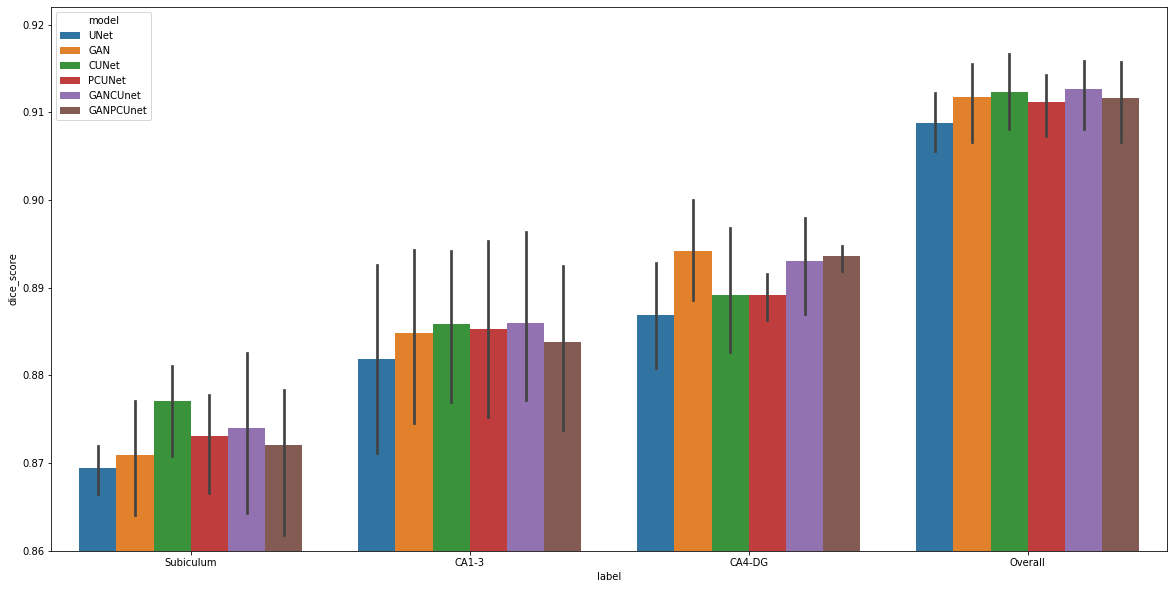

In [19]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x="label", y="dice_score", hue="model", data=results)
ax.set_ylim(0.86,0.922)

# Models Outputs

In [20]:
def construction(df , model , is_simple = True) : 
    model.eval()
    data_loader = torch.utils.data.DataLoader(
        df,
        batch_size=8,
        num_workers=4
    )
    with torch.no_grad():
        
        for bi, d in tqdm(enumerate(data_loader) , total = len(data_loader)) :
       
            y = d["label"].to(device, dtype=torch.float)

            x = d["LR"].to(device, dtype=torch.float) 
            
            y_hat   = model(x.unsqueeze(1)) #forward prop
            if is_simple == False : 
                y_hat = y_hat[:,1:,:,:]
            if bi == 0 :
                
                full_x     = x
                full_y     = y
                full_y_hat =y_hat 
            
            else :
                
                full_x     = torch.cat([full_x , x] , dim = 0 ) 
                full_y     = torch.cat([full_y , y] , dim = 0 )  
                full_y_hat = torch.cat([full_y_hat , y_hat] , dim = 0 )  
                
    return full_x.cpu().numpy() , full_y , full_y_hat

In [21]:
def write( x , path ) :  
    img = sitk.GetImageFromArray(x)
    writer = sitk.ImageFileWriter()
    writer.SetFileName(path)
    writer.Execute(img)

In [22]:
def generate_subject(subject_num , f):

        PATH_UNet = f'trained_model/UNet_segmentation/Unet Left fold {f}.pt'
        PATH_GAN = f'trained_model/GAN_segmentation/GAN Left fold {f}.pt'
        PATH_CUNet = f'trained_model/Casceded UNet/Seg Cascaded Unet V2 Left fold {f}.pt'
        PATH_PCUNet = f'trained_model/PCasceded UNet/Seg PCascaded Unet V2 Left fold {f}.pt'
        PATH_GANCUNet = f'trained_model/Casceded UNet/GAN Seg Cascaded Unet V2 Left fold {f}.pt'
        PATH_GANPCUNet = f'trained_model/PCasceded UNet/GAN Seg PCascaded Unet V2 Left fold {f}.pt'
        
        subject_df = df[df['Subject_num']==subject_num ]
        subject_df = subject_df.sort_values('slice')
        
        subject_df_dataset =  Merging_data_set(subject_df ,  subjects  , Left = True , is_train = False)
        
        model = UNet(1,4,segmentation = False )
        model = model.to(device) 
        model.load_state_dict(torch.load(PATH_UNet))
        x , y , y_hat = construction(subject_df_dataset,model)
        write(x,f'models_outputs/Segmentation/Fold {f}/Orginal_LR_subject_num_{subject_num}_fold_{f}.nii')
        
        y = soft_max_2d(y)
        write(y,f'models_outputs/Segmentation/Fold {f}/Orginal_Mask_subject_num_{subject_num}_fold_{f}.nii')
        
        y_hat = soft_max_2d(y_hat)
        write(y_hat,f'models_outputs/Segmentation/Fold {f}/UNet_predicted_Mask_subject_num_{subject_num}_fold_{f}.nii')
        
        model = UNet(1,4,segmentation = False )
        model = model.to(device)
        model.load_state_dict(torch.load(PATH_GAN))
        x , y , y_hat = construction(subject_df_dataset,model)
        
        y_hat = soft_max_2d(y_hat)
        write(y_hat,f'models_outputs/Segmentation/Fold {f}/GAN_predicted_Mask_subject_num_{subject_num}_fold_{f}.nii')

        subject_df_dataset = Merging_data_set(subject_df ,  subjects  , Left = True , is_train = False)

        model = CascadedUNet( )
        model = model.to(device)
        model.load_state_dict(torch.load(PATH_CUNet))
        x , y , y_hat = construction(subject_df_dataset,model) 
        
        y_hat = soft_max_2d(y_hat)
        write(y_hat,f'models_outputs/Segmentation/Fold {f}/CUNet_predicted_Mask_subject_num_{subject_num}_fold_{f}.nii')
        
        model = ParallelCascadedUNet()
        model = model.to(device)
        model.load_state_dict(torch.load(PATH_PCUNet))
        x , y , y_hat = construction(subject_df_dataset,model)
        
        y_hat = soft_max_2d(y_hat)
        write(y_hat,f'models_outputs/Segmentation/Fold {f}/PCUNet_predicted_Mask_subject_num_{subject_num}_fold_{f}.nii')
        
        model = GANCascadedUNet()
        model = model.to(device)
        model.load_state_dict(torch.load(PATH_GANCUNet))
        x , y , y_hat = construction(subject_df_dataset,model)
        
        y_hat = soft_max_2d(y_hat)
        write(y_hat,f'models_outputs/Segmentation/Fold {f}/GANCUNet_predicted_Mask_subject_num_{subject_num}_fold_{f}.nii')
        
        model = GANParallelCascadedUNet()
        model = model.to(device)
        model.load_state_dict(torch.load(PATH_GANPCUNet))
        x , y , y_hat = construction(subject_df_dataset,model)
        
        y_hat = soft_max_2d(y_hat)
        write(y_hat,f'models_outputs/Segmentation/Fold {f}/GANPCUNet_predicted_Mask_subject_num_{subject_num}_fold_{f}.nii')
        

In [23]:
subject_fold0 = 7
subject_fold1 = 23
subject_fold2 = 15
subject_fold3 = 10
subject_fold4 = 5

In [24]:
generate_subject(7,0)
generate_subject(23,1)
generate_subject(15,2)
generate_subject(10,3)
generate_subject(5,4)

100%|██████████| 20/20 [00:01<00:00, 14.57it/s]


# UNet

In [25]:
real_label = sitk.ReadImage( 'models_outputs/Segmentation/Fold 0/Orginal_Mask_subject_num_7_fold_0.nii' ,sitk.sitkInt8)
Real_image = sitk.ReadImage( 'models_outputs/Segmentation/Fold 0/Orginal_LR_subject_num_7_fold_0.nii')
predicted_label = sitk.ReadImage( 'models_outputs/Segmentation/Fold 0/UNet_predicted_Mask_subject_num_7_fold_0.nii' ,sitk.sitkInt8)

In [26]:
predicted_label.GetSize()

(160, 160, 159)

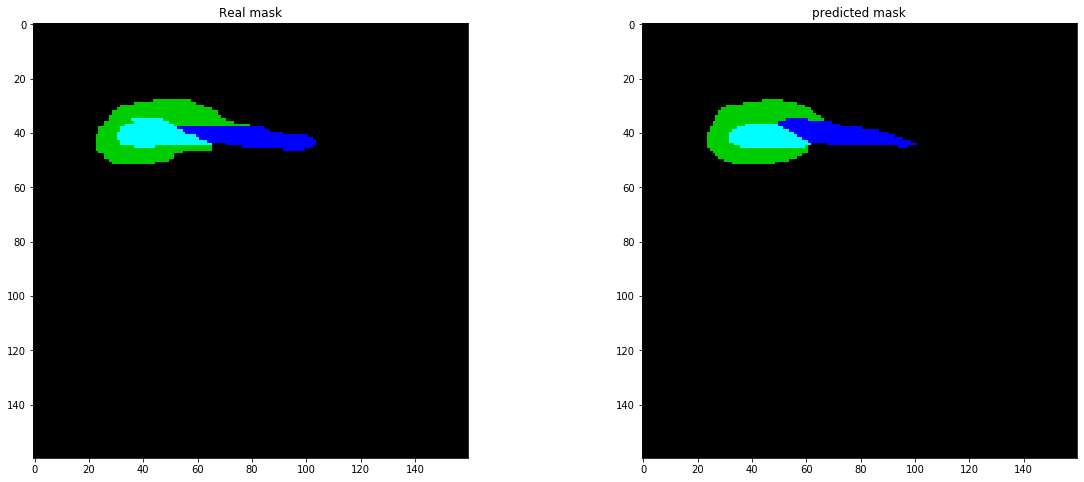

<function __main__.visualize_results(image_z, label, label_hat)>

In [27]:
interact(visualize_results, image_z=(0,real_label.GetSize()[2] - 1) , label=fixed(real_label) , label_hat = fixed(predicted_label))

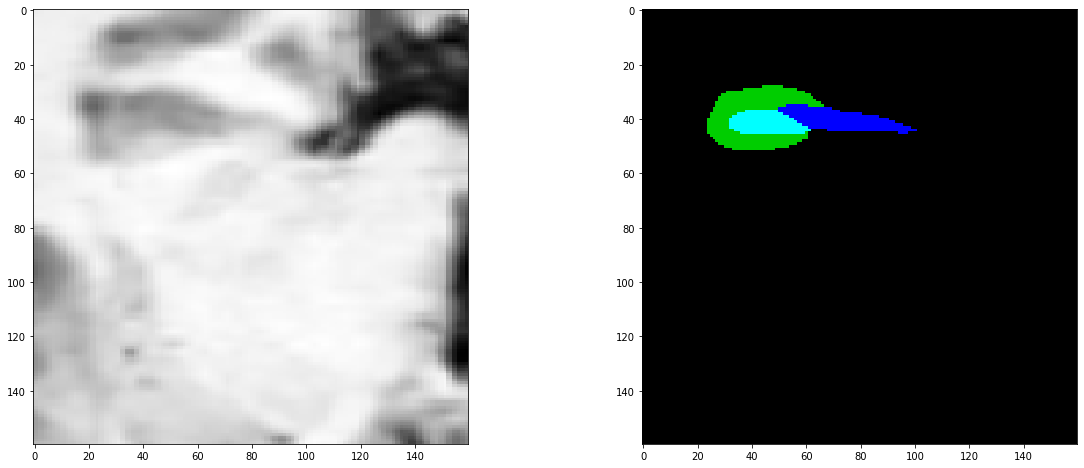

<function __main__.display_images_with_Label(image_z, alpha, im_orginal, Label)>

In [28]:
interact(display_images_with_Label, image_z=(0,real_label.GetSize()[2] - 1) , alpha = (0,1,0.1) , im_orginal=fixed(Real_image) , Label = fixed(predicted_label)) 

# GAN based on UNet

In [29]:
predicted_label = sitk.ReadImage( 'models_outputs/Segmentation/Fold 0/GAN_predicted_Mask_subject_num_7_fold_0.nii' ,sitk.sitkInt8)

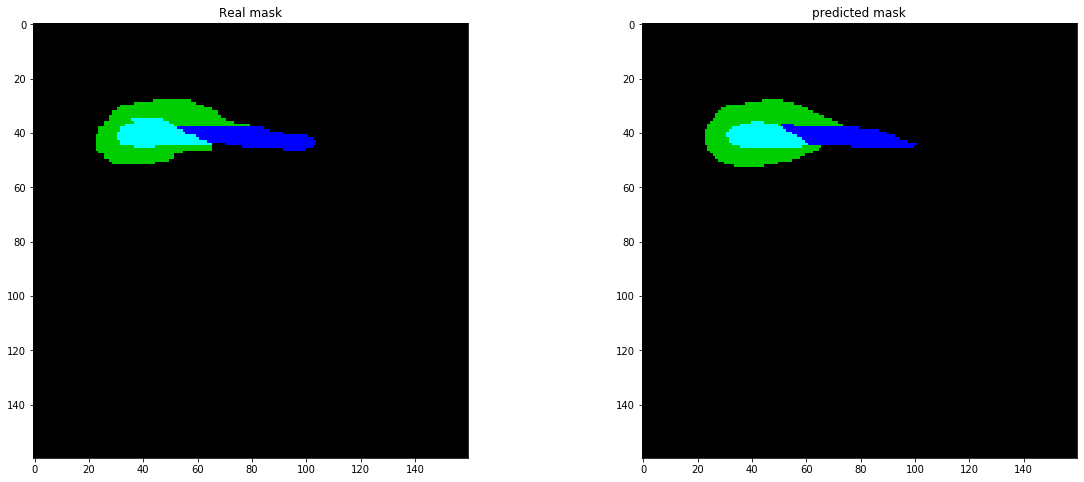

<function __main__.visualize_results(image_z, label, label_hat)>

In [30]:
interact(visualize_results, image_z=(0,real_label.GetSize()[2] - 1) , label=fixed(real_label) , label_hat = fixed(predicted_label))

# C-UNet

In [31]:
predicted_label = sitk.ReadImage( 'models_outputs/Segmentation/Fold 0/CUNet_predicted_Mask_subject_num_7_fold_0.nii' ,sitk.sitkInt8)

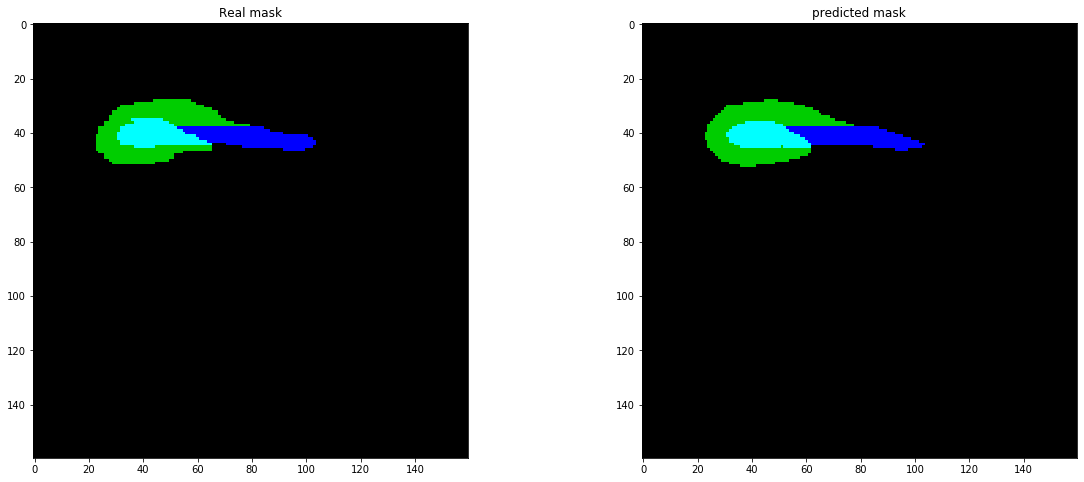

<function __main__.visualize_results(image_z, label, label_hat)>

In [32]:
interact(visualize_results, image_z=(0,real_label.GetSize()[2] - 1) , label=fixed(real_label) , label_hat = fixed(predicted_label))

# PC-UNet

In [33]:
predicted_label = sitk.ReadImage( 'models_outputs/Segmentation/Fold 0/PCUNet_predicted_Mask_subject_num_7_fold_0.nii' ,sitk.sitkInt8)

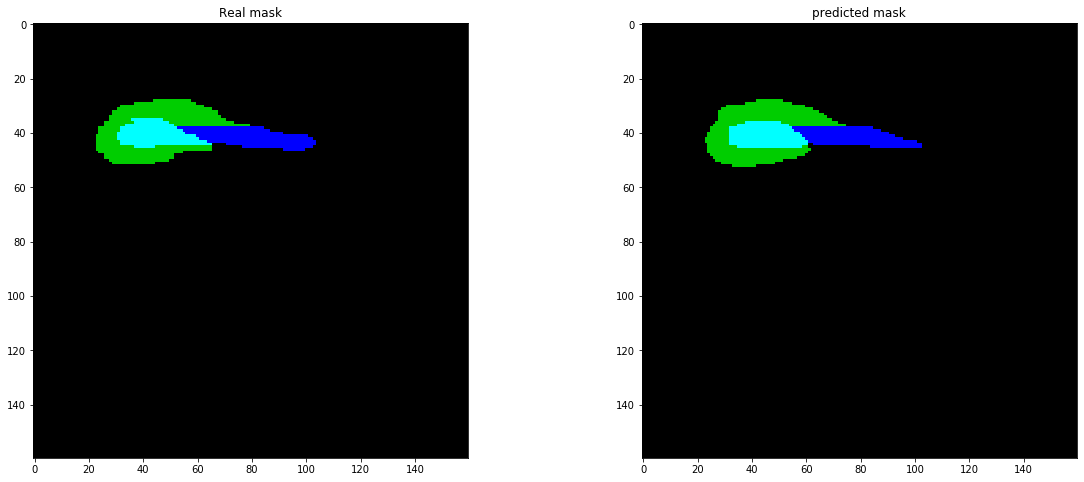

<function __main__.visualize_results(image_z, label, label_hat)>

In [34]:
interact(visualize_results, image_z=(0,real_label.GetSize()[2] - 1) , label=fixed(real_label) , label_hat = fixed(predicted_label))

# GAN based on C-UNet

In [35]:
predicted_label = sitk.ReadImage( 'models_outputs/Segmentation/Fold 0/GANCUNet_predicted_Mask_subject_num_7_fold_0.nii' ,sitk.sitkInt8)

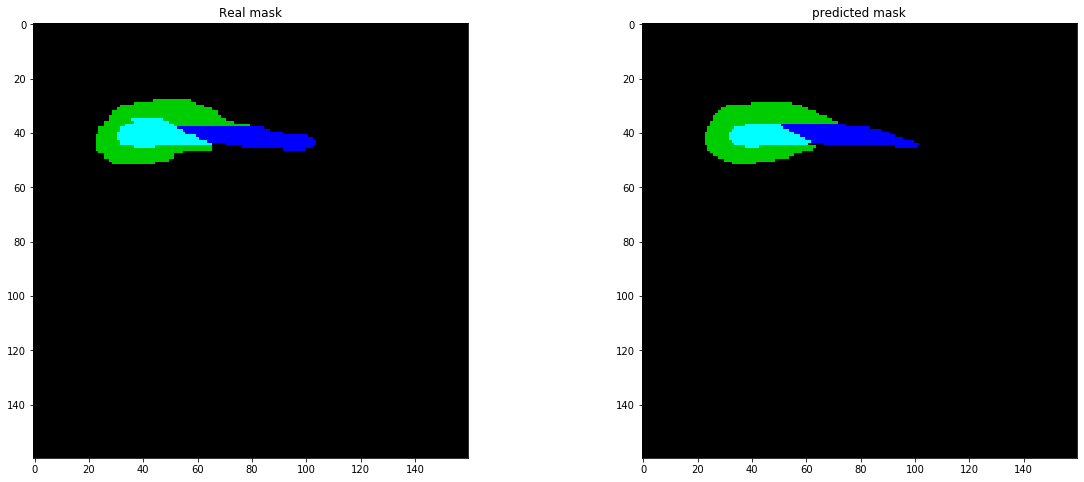

<function __main__.visualize_results(image_z, label, label_hat)>

In [36]:
interact(visualize_results, image_z=(0,real_label.GetSize()[2] - 1) , label=fixed(real_label) , label_hat = fixed(predicted_label))

# GAN based on PC-UNet

In [37]:
predicted_label = sitk.ReadImage( 'models_outputs/Segmentation/Fold 0/GANPCUNet_predicted_Mask_subject_num_7_fold_0.nii' ,sitk.sitkInt8)

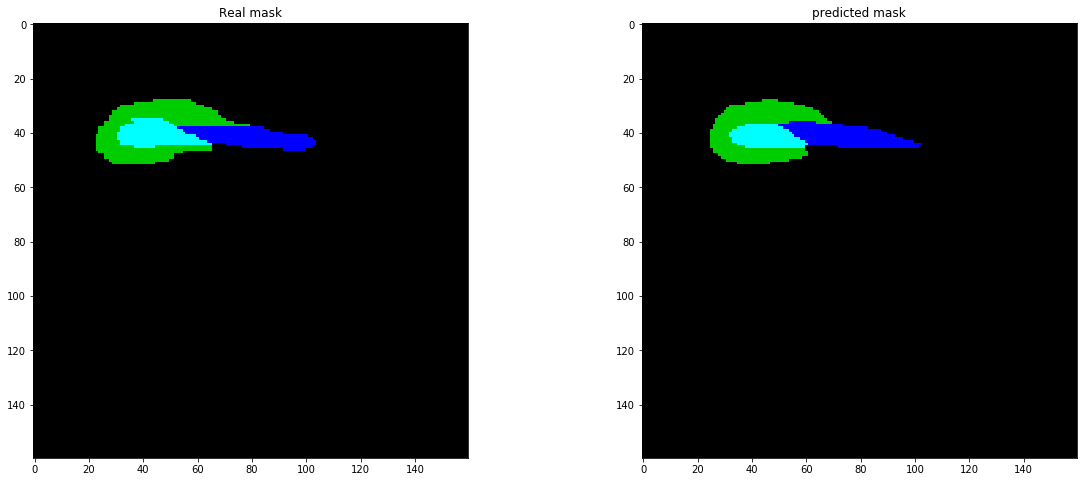

<function __main__.visualize_results(image_z, label, label_hat)>

In [38]:
interact(visualize_results, image_z=(0,real_label.GetSize()[2] - 1) , label=fixed(real_label) , label_hat = fixed(predicted_label))

In [52]:
import json